# TMY data and diffuse irradiance models

This tutorial explores using TMY data as inputs to different plane of array diffuse irradiance models.

This tutorial requires pvlib > 0.6.0.

Authors:
* Rob Andrews (@Calama-Consulting), Heliolytics, June 2014
* Will Holmgren (@wholmgren), University of Arizona, July 2015, March 2016, August 2018

## Setup

See the ``tmy_to_power`` tutorial for more detailed explanations for the initial setup

In [1]:
# built-in python modules
import os
import inspect

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt

# finally, we import the pvlib library
import pvlib

In [2]:
# Find the absolute file path to your pvlib installation
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

# absolute path to a data file
datapath = os.path.join(pvlib_abspath, 'data', '703165TY.csv')

# read tmy data with year values coerced to a single year
tmy_data, meta = pvlib.tmy.readtmy3(datapath, coerce_year=2015)
tmy_data.index.name = 'Time'

# TMY data seems to be given as hourly data with time stamp at the end
# shift the index 30 Minutes back for calculation of sun positions
tmy_data = tmy_data.shift(freq='-30Min')['2015']

Text(0,0.5,'Irradiance (W/m**2)')

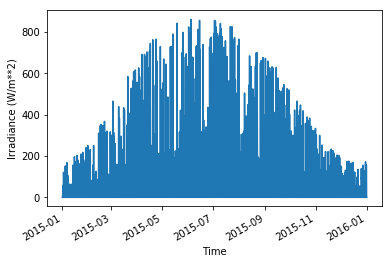

In [3]:
tmy_data.GHI.plot()
plt.ylabel('Irradiance (W/m**2)')

Text(0,0.5,'Irradiance (W/m**2)')

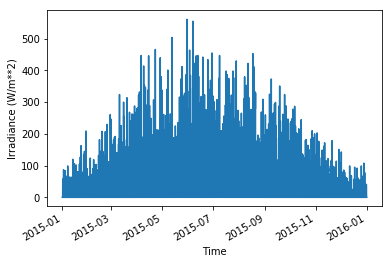

In [4]:
tmy_data.DHI.plot()
plt.ylabel('Irradiance (W/m**2)')

In [5]:
surface_tilt = 30
surface_azimuth = 180 # pvlib uses 0=North, 90=East, 180=South, 270=West convention
albedo = 0.2

# create pvlib Location object based on meta data
sand_point = pvlib.location.Location(meta['latitude'], meta['longitude'], tz='US/Alaska', 
                                     altitude=meta['altitude'], name=meta['Name'].replace('"',''))
print(sand_point)

Location: 
  name: SAND POINT
  latitude: 55.317
  longitude: -160.517
  altitude: 7.0
  tz: US/Alaska


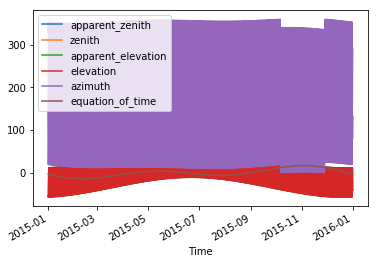

In [6]:
solpos = pvlib.solarposition.get_solarposition(tmy_data.index, sand_point.latitude, sand_point.longitude)

solpos.plot()

Text(0,0.5,'Extra terrestrial radiation (W/m**2)')

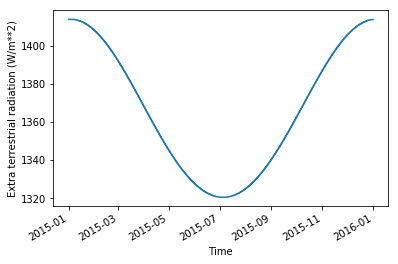

In [7]:
# the extraradiation function returns a simple numpy array
# instead of a nice pandas series. We will change this
# in a future version
dni_extra = pvlib.irradiance.get_extra_radiation(tmy_data.index)
dni_extra = pd.Series(dni_extra, index=tmy_data.index)

dni_extra.plot()
plt.ylabel('Extra terrestrial radiation (W/m**2)')

Text(0,0.5,'Airmass')

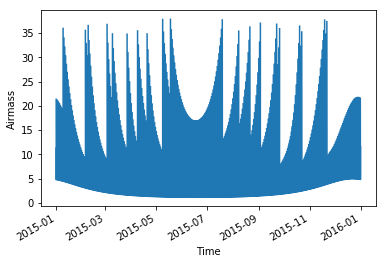

In [8]:
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])

airmass.plot()
plt.ylabel('Airmass')

## Diffuse irradiance models

Make an empty pandas DataFrame for the results.

In [9]:
diffuse_irrad = pd.DataFrame(index=tmy_data.index)

In [10]:
models = ['Perez', 'Hay-Davies', 'Isotropic', 'King', 'Klucher', 'Reindl']

### Perez

In [11]:
diffuse_irrad['Perez'] = pvlib.irradiance.perez(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth,
                               airmass=airmass)

### HayDavies

In [12]:
diffuse_irrad['Hay-Davies'] = pvlib.irradiance.haydavies(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)

### Isotropic

In [13]:
diffuse_irrad['Isotropic'] = pvlib.irradiance.isotropic(surface_tilt,
                               dhi=tmy_data.DHI)

### King Diffuse model

In [14]:
diffuse_irrad['King'] = pvlib.irradiance.king(surface_tilt,
                               dhi=tmy_data.DHI,
                               ghi=tmy_data.GHI,
                               solar_zenith=solpos.apparent_zenith)

### Klucher Model

In [15]:
diffuse_irrad['Klucher'] = pvlib.irradiance.klucher(surface_tilt, surface_azimuth,
                                                    dhi=tmy_data.DHI,
                                                    ghi=tmy_data.GHI,
                                                    solar_zenith=solpos.apparent_zenith,
                                                    solar_azimuth=solpos.azimuth)

### Reindl

In [16]:
diffuse_irrad['Reindl'] = pvlib.irradiance.reindl(surface_tilt,
                               surface_azimuth,
                               dhi=tmy_data.DHI,
                               dni=tmy_data.DNI,
                               ghi=tmy_data.GHI,
                               dni_extra=dni_extra,
                               solar_zenith=solpos.apparent_zenith,
                               solar_azimuth=solpos.azimuth)

Calculate yearly, monthly, daily sums.

In [17]:
yearly = diffuse_irrad.resample('A', how='sum').dropna().squeeze() / 1000.0  # kWh
monthly = diffuse_irrad.resample('M', how='sum', kind='period') / 1000.0
daily = diffuse_irrad.resample('D', how='sum') / 1000.0

/Users/holmgren/miniconda3/envs/pvlibfx36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.
/Users/holmgren/miniconda3/envs/pvlibfx36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  
/Users/holmgren/miniconda3/envs/pvlibfx36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  This is separate from the ipykernel package so we can avoid doing imports until


## Plot Results

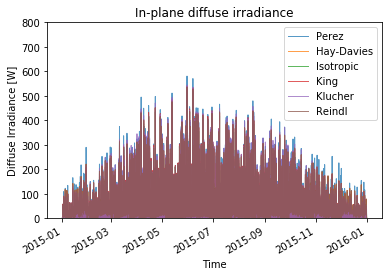

In [18]:
ax = diffuse_irrad.plot(title='In-plane diffuse irradiance', alpha=.75, lw=1)
ax.set_ylim(0, 800)
ylabel = ax.set_ylabel('Diffuse Irradiance [W]')
plt.legend()

In [19]:
diffuse_irrad.describe()

,Perez,Hay-Davies,Isotropic,King,Klucher,Reindl
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,4578.000000
mean,55.404468,52.432929,49.100286,53.073101,53.620056,100.715271
std,80.441611,75.458356,72.136293,76.342443,78.797163,78.428181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,39.033711
50%,3.732051,3.732051,3.732051,4.009665,3.732051,87.265688
75%,95.390948,91.321869,81.172105,91.777292,90.936414,145.523600
max,580.694617,533.102519,523.420126,538.809780,544.508380,535.970735


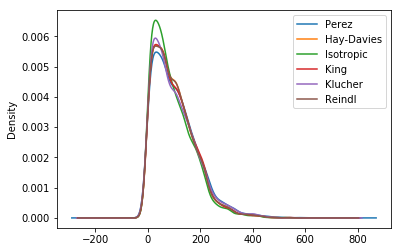

In [20]:
diffuse_irrad.dropna().plot(kind='density')

Daily

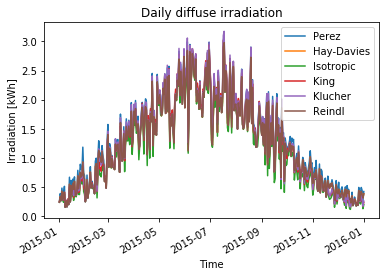

In [21]:
ax_daily = daily.tz_convert('UTC').plot(title='Daily diffuse irradiation')
ylabel = ax_daily.set_ylabel('Irradiation [kWh]')

Monthly

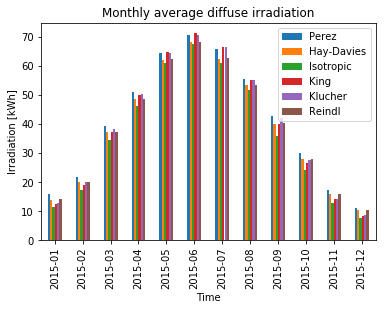

In [22]:
ax_monthly = monthly.plot(title='Monthly average diffuse irradiation', kind='bar')
ylabel = ax_monthly.set_ylabel('Irradiation [kWh]')

Yearly

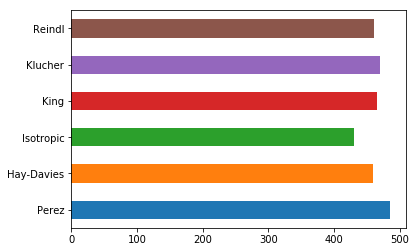

In [23]:
yearly.plot(kind='barh')

Compute the mean deviation from measured for each model and display as a function of the model

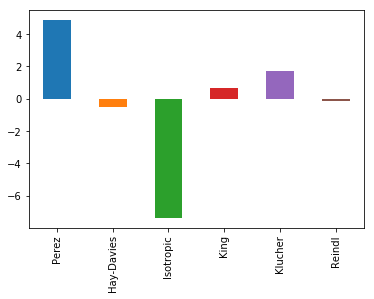

In [24]:
mean_yearly = yearly.mean()
yearly_mean_deviation = (yearly - mean_yearly) / yearly * 100.0
yearly_mean_deviation.plot(kind='bar')